Analyze training results

In [1]:
%load_ext autoreload
%autoreload 2

In [219]:
import sys
sys.path.append('../')
import lightning as L
import torch
import models.modules.transformer
import models.datasets.phla
import attention

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

Load data and model from checkpoint

In [13]:
# Configure data
hits_file = '../data/hits_16_9.txt'
decoys_file = None
aa_order_file = '../data/amino_acid_ordering.txt'
allele_sequence_file = '../data/alleles_95_variable.txt'

data = models.datasets.phla.PeptideHLADataModule(
    hits_file=hits_file,
    decoys_file=decoys_file,
    aa_order_file=aa_order_file,
    allele_sequence_file=allele_sequence_file,
    decoy_mul=1,
    train_test_split=1.0,
    batch_size=64,
    shuffle=False
)
data.prepare_data()

# Load the model and patch to recover attention outputs
model = models.modules.transformer.PeptideHLATransformer.load_from_checkpoint("../logs/hits_16/epoch=9-step=6260.ckpt")
attn_outputs = attention.patch_attention(model)

# Run predictions
trainer = L.Trainer()
predictions = trainer.predict(model, datamodule=data)

Lightning automatically upgraded your loaded checkpoint from v1.9.1 to v2.0.0dev. To apply the upgrade to your files permanently, run `python -m lightning.pytorch.utilities.upgrade_checkpoint --file ../logs/hits_16/epoch=9-step=6260.ckpt`
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /Users/mbakalar/Documents/Hacohen/Computational/peptide-hla-ai/analysis/lightning_logs
/Users/mbakalar/opt/anaconda3/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:217: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 251/251 [01:16<00:00,  3.29it/s]


Analyze model attention

In [31]:
data_avg = torch.vstack(list(attn_outputs[1].outputs)).mean(axis=0)

/var/folders/zx/cktqv751087bh3h282sl63nr0000gp/T/ipykernel_55085/1466604369.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(5, 5))


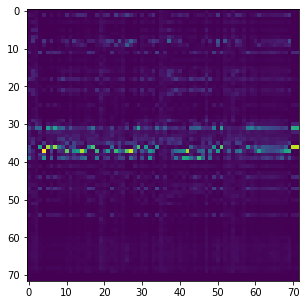

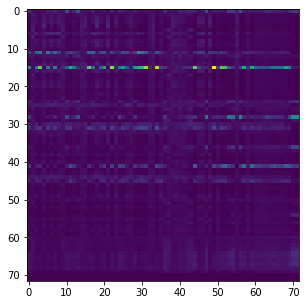

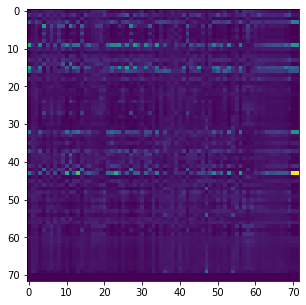

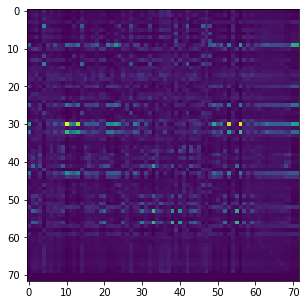

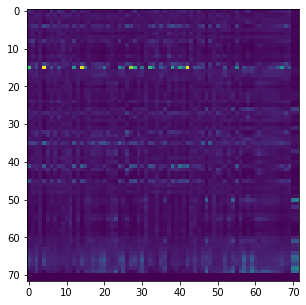

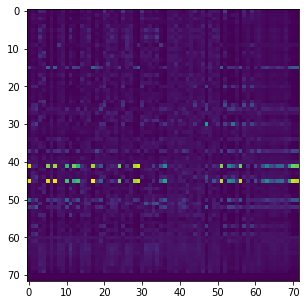

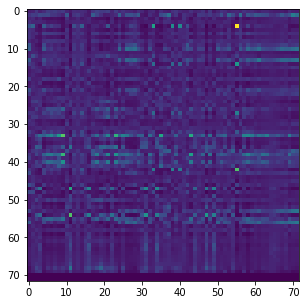

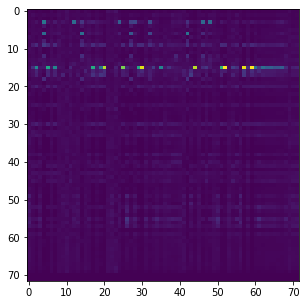

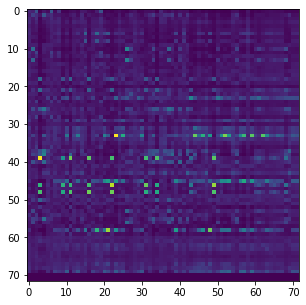

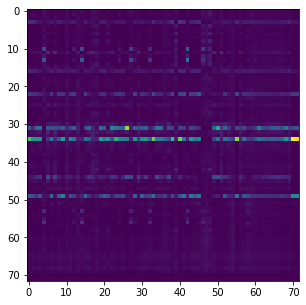

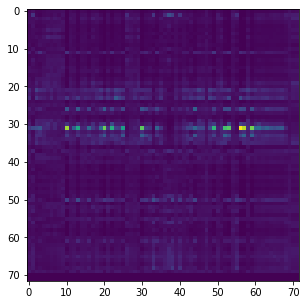

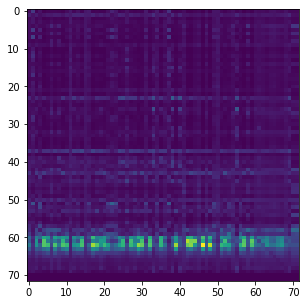

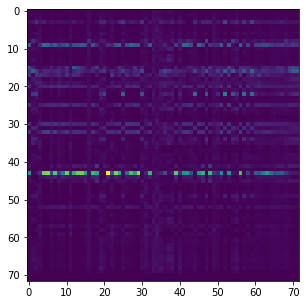

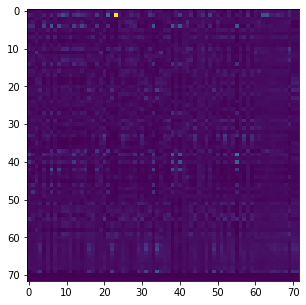

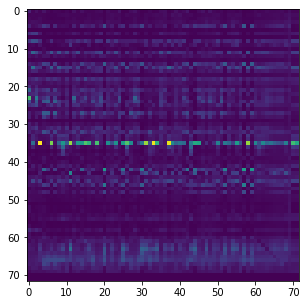

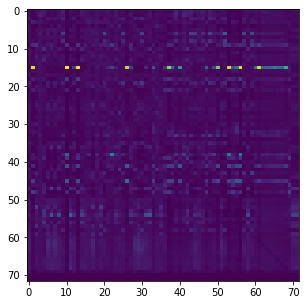

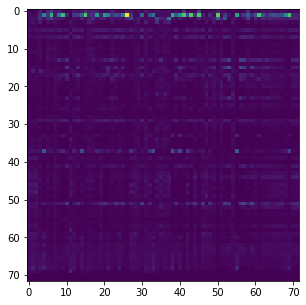

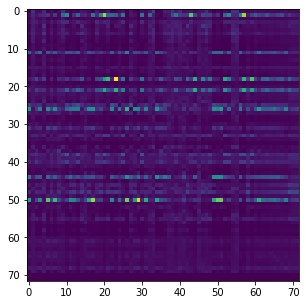

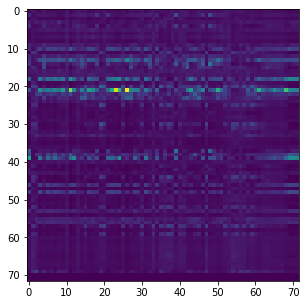

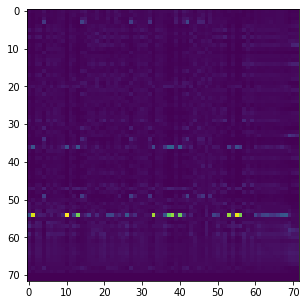

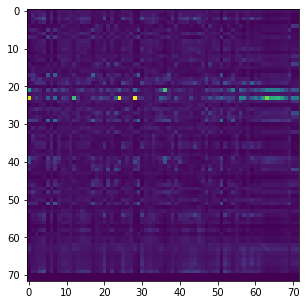

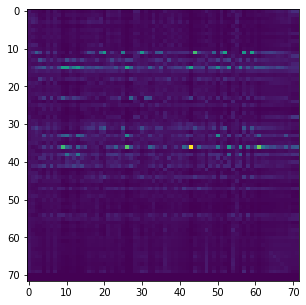

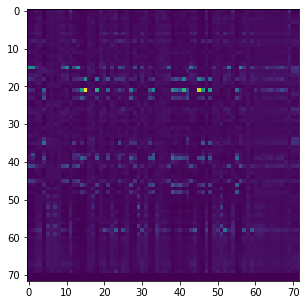

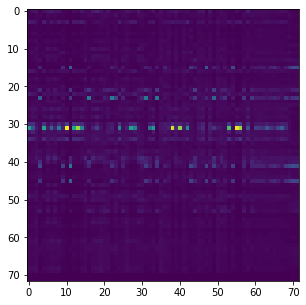

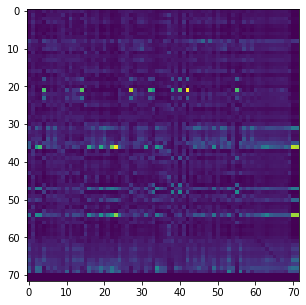

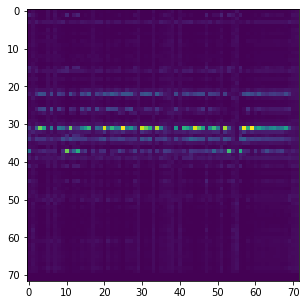

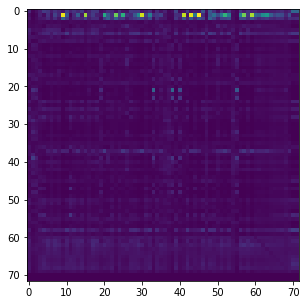

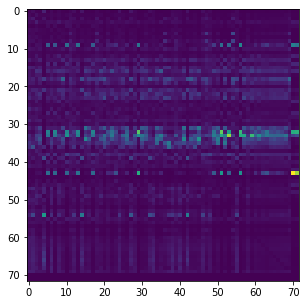

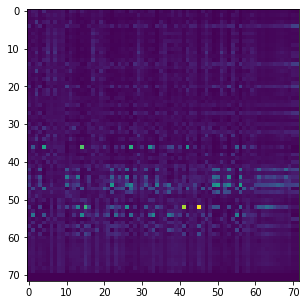

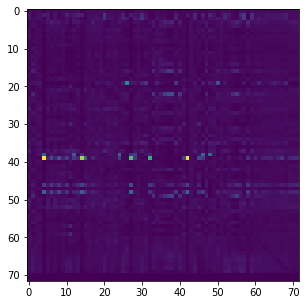

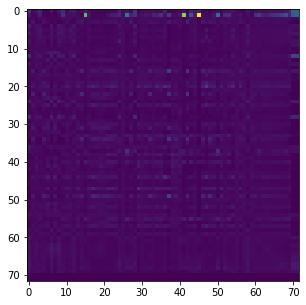

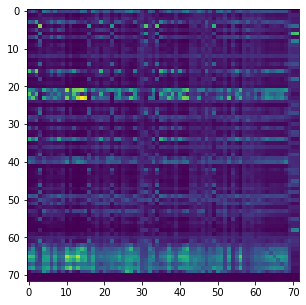

In [186]:
import numpy as np
for head in np.arange(0,32):
    attention = data_avg[head]
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(torch.transpose(attention, 0, 1))

(60,)


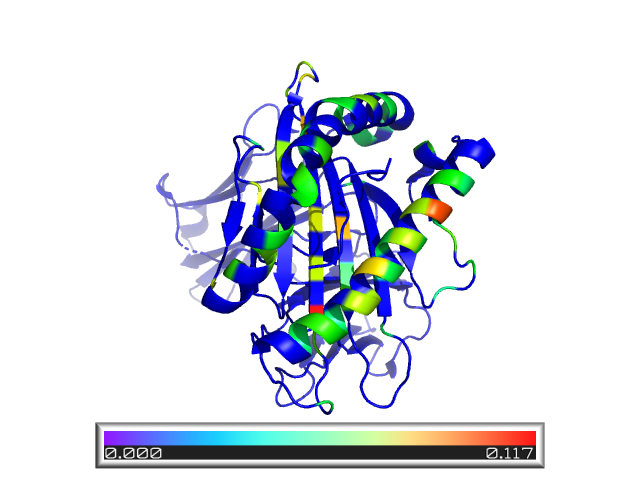

In [247]:
import bfactors
from pymol import cmd

head = 0

hla_head_vals = data_avg[head,0:60,0:60].mean(axis=0).numpy()
hla_head_mean = data_avg.mean(axis=0)[0:60,0:60].mean(axis=0).numpy()

# Fill in protein sites that are not processed by Transformer
hla_attn = bfactors.map_data_to_sites(hla_head_vals, '../data/variable_sites.txt')
hla_mean_attn = bfactors.map_data_to_sites(hla_head_mean, '../data/variable_sites.txt')

# Peptide level attention
pep_attn = data_avg[head,0:60,60:].mean(axis=1).numpy()
pep_mean_attn = data_avg.mean(axis=0)[0:60,60:].mean(axis=1).numpy()



# PyMol commands
cmd.load('../data/1jf1.pdb')
cmd.alter('1jf1',"b=0")

bfactors.reassign_b_factors('1jf1', 'A', hla_sum_attn)
bfactors.reassign_b_factors('1jf1', 'C', pep_head_sum*100)

cmd.remove('resn hoh')
cmd.spectrum("b", "rainbow", "%s and n. CA " % '1jf1')
cmd.ramp_new("count", '1jf1', [min(hla_attn), max(hla_attn)], "rainbow")
cmd.recolor()
cmd.ipython_image()

In [194]:

mol = '1jf1'
cmd.delete('1jf1')
cmd.load('../data/1jf1.pdb')

startaa=1
counter=int(startaa)
for val in hla_attn:	
    cmd.alter("%s and resi %s and n. CA"%(mol,counter), "b=%s"%val)
    counter=counter+1

cmd.spectrum("b","rainbow", "%s and n. CA " %mol)

(0.0, 61.630001068115234)

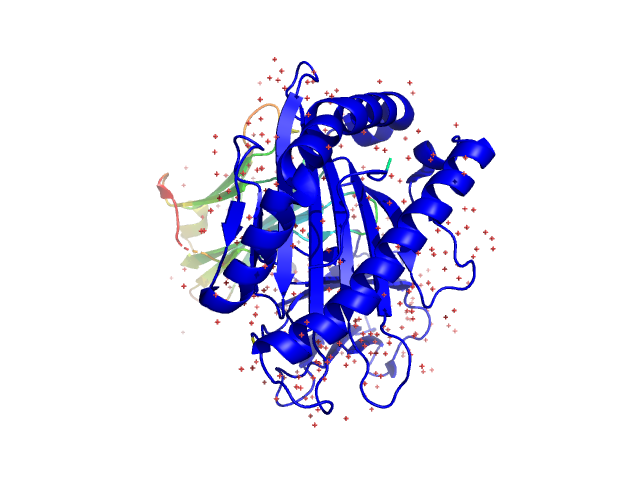

In [195]:
cmd.ipython_image()

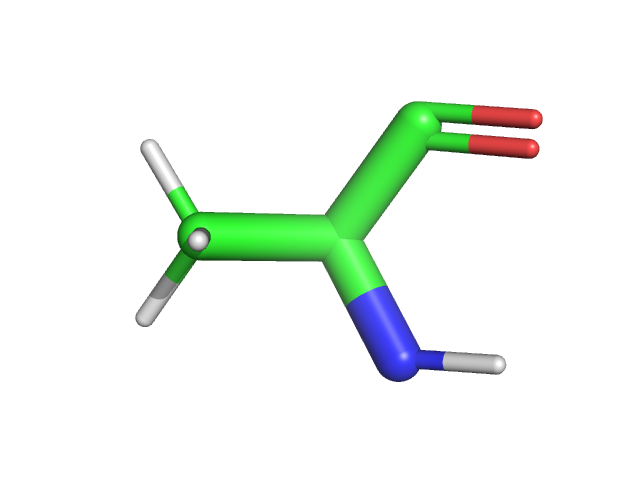

In [4]:
cmd.fragment('ala')
cmd.orient()

# since PyMOL 2.5
cmd.ipython_image()